In [1]:
from typing import Annotated, Sequence, TypedDict, List

from langchain_core.messages import BaseMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool

from langchain_google_genai import ChatGoogleGenerativeAI

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode

from dotenv import load_dotenv
load_dotenv()

import os

In [2]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = os.getenv("GEMINI_API_KEY")

In [3]:
### in the exercise the agent will be able to read from a text file and write to it 
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [27]:
@tool
def file_exisits(file_path: str) -> str:
    "checks if a file exists"
    if os.path.exists(file_path):
        return "File exists"
    else:
        return "File does not exist"

@tool
def read_file(file_path: str) -> str:
    "reads from a file"
    with open(file_path, "r") as f:
        return f.read()

@tool
def write_file(file_path: str, content: str) -> str:
    "writes to a file"
    with open(file_path, "w") as f:
        f.write(content)
    return "File written"

@tool
def list_files() -> List[str]:
    "lists all files in the current directory"
    return os.listdir()

@tool 
def delete_file(file_path: str) -> str:
    "deletes a file"
    os.remove(file_path)
    return "File deleted"

In [28]:
tools = [file_exisits,read_file,write_file,list_files,delete_file]

llm = ChatGoogleGenerativeAI(
    model = "gemini-2.0-flash",
    temperature = 0.7
).bind_tools(tools)

In [29]:
# actions
def controller(state:State) -> State:
    """control the flow of the agent"""
    system_message = SystemMessage(content="You are a helpful assistant. utilize you tools to help the user edit the current file directory.")
    response = llm.invoke([system_message] + state["messages"])
    # print("current state: ",state['messages'])
    return {"messages" : [response]}

def check_for_tool_nessecety(state:State) -> State:
    """check for tool necessity"""
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

In [30]:
# intialize graph
graph = StateGraph(State)

# add nodes
graph.add_node("Agent_Control", controller)
tool_node = ToolNode(tools)
graph.add_node("tools", tool_node)

# add edges
graph.add_edge(START, "Agent_Control")
graph.add_conditional_edges(
    "Agent_Control",
    check_for_tool_nessecety,
    {
        #edge:nood
        "end" : END,
        "continue": "tools"
    }
)
graph.add_edge("tools", "Agent_Control")

# compile graph
app = graph.compile()

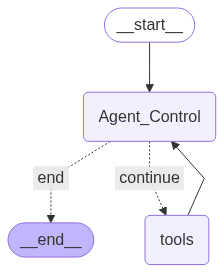

In [31]:
from IPython.display import Image
display(Image(app.get_graph().draw_mermaid_png()))

In [32]:
def print_stream(stream):
    for s in stream:
        message = s['messages'][-1]
        if isinstance(message, tuple):
            print(message)
        else: 
            message.pretty_print()

In [25]:
inputs = {"messages": ("user","create new text file in the current directory called test.txt write testing writing function in it")}
print_stream(app.stream(inputs,stream_mode="values"))

================================ Human Message =================================

create new text file in the current directory called test.txt write testing writing function in it
================================== Ai Message ==================================
Tool Calls:
  write_file (e558fcd9-11dd-4c8c-b839-a8c48a0faf15)
 Call ID: e558fcd9-11dd-4c8c-b839-a8c48a0faf15
  Args:
    file_path: test.txt
    content: testing writing function
================================= Tool Message =================================
Name: write_file

File written
================================== Ai Message ==================================

I have created a file called test.txt and wrote "testing writing function" in it.


In [26]:
result = app.invoke({"messages":['user','create another file in the current directory called test_2.txt and write the following text in it: This is a test file']})
result['messages']

[HumanMessage(content='user', additional_kwargs={}, response_metadata={}, id='d4de251f-3a4f-4804-aedd-2c18400e06c4'),
 HumanMessage(content='create another file in the current directory called test_2.txt and write the following text in it: This is a test file', additional_kwargs={}, response_metadata={}, id='fd98cf88-1b62-4dac-bd15-a1575dd9c9f8'),
 AIMessage(content='', additional_kwargs={'function_call': {'name': 'write_file', 'arguments': '{"file_path": "test_2.txt", "content": "This is a test file"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--4ea5ae7d-593b-412c-b275-f30bf2e8c48a-0', tool_calls=[{'name': 'write_file', 'args': {'file_path': 'test_2.txt', 'content': 'This is a test file'}, 'id': '4c2a5fcf-25a4-41ad-9a00-8a0f47ad83f2', 'type': 'tool_call'}], usage_metadata={'input_tokens': 107, 'output_tokens': 17, 'total_tokens': 124, 'input_token_details'

In [33]:
result = app.invoke({"messages":['user','delete file named test_2.txt in the current directory']})
result['messages'][-1]

AIMessage(content="OK. I've deleted the file test_2.txt. Anything else?", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--eef3674d-171d-45b4-b6d4-601266e45029-0', usage_metadata={'input_tokens': 125, 'output_tokens': 18, 'total_tokens': 143, 'input_token_details': {'cache_read': 0}})